In [1]:
import glob
from os.path import join
import os

import rpy2.rinterface
from pandas import DataFrame, concat
from qiime2 import Artifact
from numpy import argsort
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)
library(reshape2)
library(scales) # trans_new() is in the scales library

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3'

In [5]:
types = []
weightses = []
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'plant-surface',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
type_map = dict(zip(old_labels, new_labels))
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'weights.qza')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    types.append(type_map[type_])
    weights = Artifact.load(join(type_dir, 'results', 'weights.qza'))
    weightses.append(weights.view(DataFrame))

In [6]:
weightrix = concat(weightses)
weightrix.index = types
weightrix = weightrix.T

sample_types = []
weightses = []
num_taxa = []
taxa = []
for type_ in types:
    sample_types.append(type_)
    weightses.append(0.)
    num_taxa.append(0)
    taxa.append('zero')
    weightrix = weightrix.iloc[weightrix[type_].argsort()].iloc[::-1]
    for num, (taxon, weight) in enumerate(weightrix[type_].items()):
        sample_types.append(type_)
        weightses.append(weightses[-1] + weight)
        num_taxa.append(num)
        taxa.append(taxon)

figure5 = DataFrame({
    'sample type': sample_types,
    'weight': weightses,
    'num taxa': num_taxa,
    'taxon': taxa
})

old_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
new_labels = [
    'Animal',
    'Animal',
    'Animal',
    'Animal',
    'Animal',
    'Plant',
    'Plant',
    'Plant',
    'Non-saline',
    'Non-saline',
    'Non-saline',
    'Non-saline',
    'Saline',
    'Saline',
    'Saline'
]
for old, new in zip(old_labels, new_labels):
    figure5.loc[figure5['sample type'] == old, 'empo2'] = new

In [7]:
%%R -i figure5

figure5$empo2 = factor(figure5$empo2, levels=c(
    'Saline', 'Non-saline', 'Plant', 'Animal'))
cbPalette <- c("#999999", "#56B4E9", "#E69F00", "#009E73", "#F0E442", "#0072B2", "#D55E00")
ggplot(figure5, aes(x=num.taxa, y=weight, group=sample.type, colour=empo2)) +
    theme_bw() + labs(x='Number of Taxa', y='Cumulative Weight') +
    geom_line() + xlim(0,1500) + ylim(0.8, 1) + scale_colour_manual(values=cbPalette) +
    guides(colour=guide_legend(title="EMPO 2 Habitat Type", nrow=2, byrow=TRUE)) +
    theme(legend.position="bottom", 
          legend.direction="horizontal")
ggsave(file="figure5.png", width=5, height=5, dpi=900)

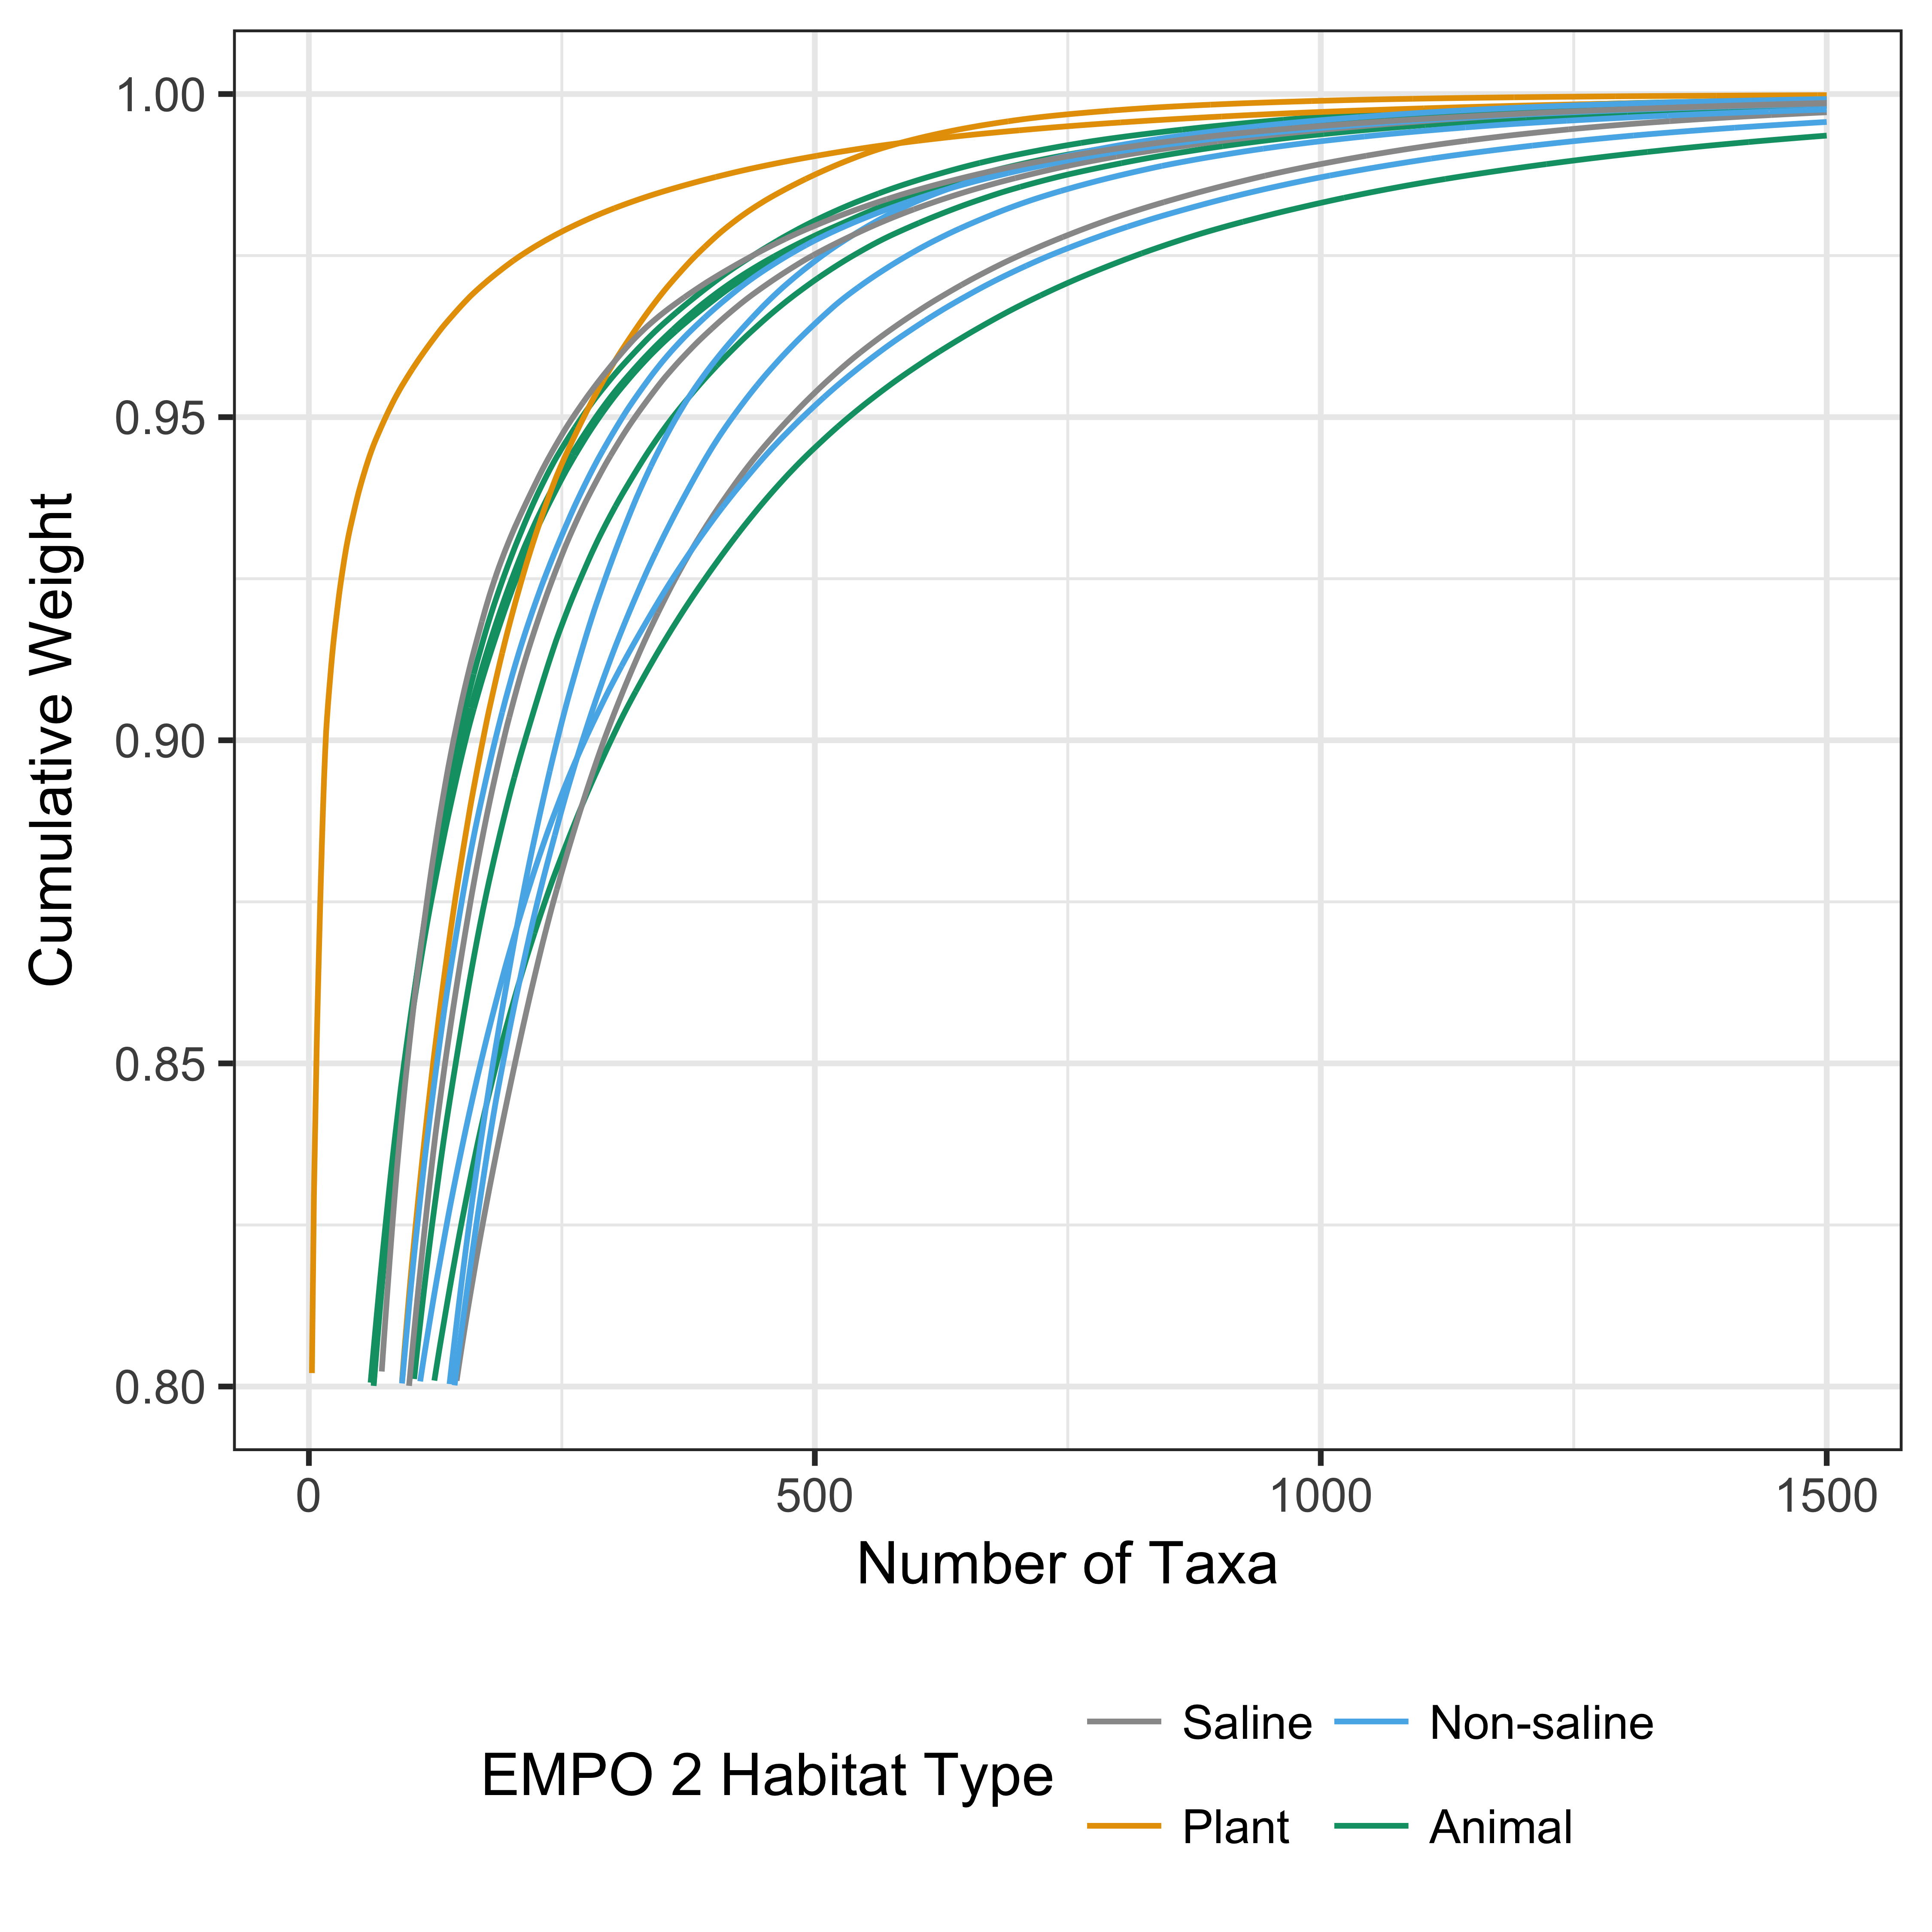

In [8]:
Image("figure5.png")

In [177]:
len(set(figure5[figure5['weight'] <= 0.95]['taxon'])) - 1

1571

In [33]:
weightrix = concat(weightses)
#weightrix.index = types
weightrix = weightrix.iloc[:,argsort(list(weightrix.sum(axis=0)))].iloc[:,::-1]
for i in range(1, weightrix.shape[1]):
    weightrix.iloc[:,i] += weightrix.iloc[:,i-1]
weightrix = weightrix.append(DataFrame(weightrix.sum(axis=0)/len(weightrix), columns=['total']).T)

In [35]:
%%R -i weightrix
meltrix <- melt(weightrix, id=c('sample.type', 'total'))
#meltrix$sample.type = factor(meltrix$sample.type, levels=c(
#     'Water (saline)',
#     'Surface (saline)',
#     'Sediment (saline)',
#     'Water (non-saline)',
#     'Surface (non-saline)',
#     'Soil (non-saline)',
#     'Sediment (non-saline)',
#     'Plant surface',
#     'Plant rhizosphere',
#     'Plant corpus',
#     'Animal surface',
#     'Animal secretion',
#     'Animal proximal gut',
#     'Animal distal gut',
#     'Animal corpus'
#))
ggplot(meltrix, aes(x=total, y=value, group=sample.type)) +
    geom_line() +
    theme_bw() +
    theme(axis.text.x=element_blank(),
          axis.ticks.x=element_blank())
#ggplot(meltrix,
#       aes(x=variable, y=sample.type, fill=value)) + 
#    geom_raster() + 
#    scale_fill_distiller(palette="RdYlBu", trans="log10") + 
#    theme_classic() +
#    theme(axis.text.x=element_blank(),
#          axis.ticks.x=element_blank(),
#          axis.line=element_blank()) +
#    labs(x='Taxonomy', y='EMPO3 Habitat', fill='Weight')
ggsave(file="figure5.png", width=5, height=5, dpi=900)


Error: id variables not found in data: sample.type, total


/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: id variables not found in data: sample.type, total

  warnings.warn(x, RRuntimeWarning)


In [36]:
#weightrix = weightrix.iloc[argsort(list(weightrix.index))].iloc[::-1]
#min_weight = weightrix.sum(axis=1).min()
#weightrix = weightrix.loc[weightrix.sum(axis=1) > min_weight + 1e-9]
#for i in range(1, len(weightrix)):
#    weightrix.iloc[i] += weightrix.iloc[i-1]
#sample_types = []
#weightses = []
#num_taxa = []
#taxa = []
#for type_ in types:
#    sample_types.append(type_)
#    weightses.append(0.)
#    num_taxa.append(0)
#    taxa.append('zero')
#for num, (taxon, weights) in enumerate(weightrix.iterrows()):
#    for type_ in weights.index:
#        if type_ == 'mean':
#            continue
#        sample_types.append(type_)
#        weightses.append(weights[type_])
#        num_taxa.append(num)
#        taxa.append(taxon)

soil_weights <- figure5$weight[figure5$sample.type == 'Soil (non-saline)']
forward_single <- function(x) soil_weights[x+1]
forward <- function(x) as.matrix(unlist(lapply(x, forward_single)))
reverse_single <- function(x) which(abs(soil_weights-x) == min(abs(soil_weights-x))) - 1
reverse <- function(x) as.matrix(sapply(x, reverse_single))

require(scales) # trans_new() is in the scales library
soiled_trans = function() trans_new("soiled", forward, reverse)

,k__Archaea; p__; c__; o__; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__; o__; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__AAG; o__; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__[Caldiarchales]; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__[Caldiarchales]; f__[Caldiarchaceae]; g__; s__,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__[Caldiarchales]; f__[Caldiarchaceae]; g__Caldiarchaeum; s__subterraneum,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__[Caldiarchales]; f__[Caldiarchaceae]; g__Candidatus Caldiarchaeum; s__,k__Archaea; p__Crenarchaeota; c__Korarchaeota; o__Korarchaeotales; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__Korarchaeota; o__Korarchaeotales; f__Korarchaeotaceae; g__; s__,...,k__Bacteria; p__[Thermi]; c__Deinococci; o__Deinococcales; f__Trueperaceae; g__B-42; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Deinococcales; f__Trueperaceae; g__GBI-58; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Deinococcales; f__Trueperaceae; g__Truepera; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Marinithermus; s__hydrothermalis,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Meiothermus; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Oceanithermus; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Thermus; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Vulcanithermus; s__,sample type
Weight,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,...,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06,5.969667e-06
Weight,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,...,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10
Weight,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,...,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07,3.626164e-07
Weight,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,...,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08,9.141972e-08
Weight,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,...,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05,5.642828e-05
Weight,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,...,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10
Weight,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,...,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08,5.030944e-08
Weight,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,...,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10
Weight,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,1.850824e-10,...,1.850824e-10,1.850824e-10,1.850824e-10

In [64]:
weightrix = weightrix.reindex(sorted(weightrix.columns), axis=1)
empo3_order = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'plant-surface',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
weightrix = weightrix.reindex(empo3_order, axis=0)

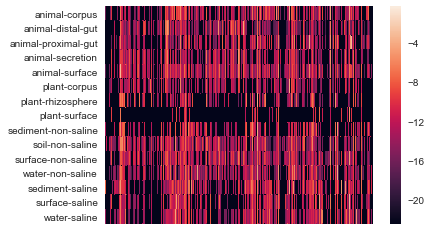

In [65]:
sns.heatmap(weightrix, xticklabels=False)

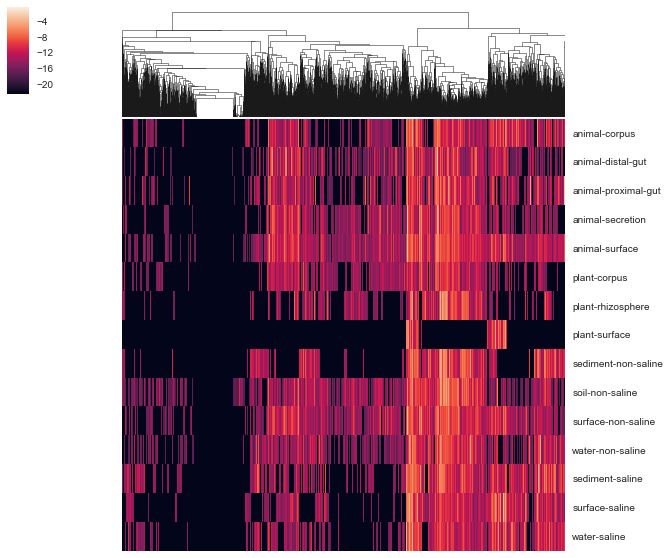

In [66]:
sns.clustermap(weightrix, xticklabels=False, row_cluster=False)

In [53]:
weightrix

,k__Archaea; p__; c__; o__; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__; o__; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__AAG; o__; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__[Caldiarchales]; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__[Caldiarchales]; f__[Caldiarchaceae]; g__; s__,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__[Caldiarchales]; f__[Caldiarchaceae]; g__Caldiarchaeum; s__subterraneum,k__Archaea; p__Crenarchaeota; c__Aigarchaeota; o__[Caldiarchales]; f__[Caldiarchaceae]; g__Candidatus Caldiarchaeum; s__,k__Archaea; p__Crenarchaeota; c__Korarchaeota; o__Korarchaeotales; f__; g__; s__,k__Archaea; p__Crenarchaeota; c__Korarchaeota; o__Korarchaeotales; f__Korarchaeotaceae; g__; s__,...,k__Bacteria; p__[Thermi]; c__Deinococci; o__Deinococcales; f__Trueperaceae; g__; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Deinococcales; f__Trueperaceae; g__B-42; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Deinococcales; f__Trueperaceae; g__GBI-58; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Deinococcales; f__Trueperaceae; g__Truepera; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Marinithermus; s__hydrothermalis,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Meiothermus; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Oceanithermus; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Thermus; s__,k__Bacteria; p__[Thermi]; c__Deinococci; o__Thermales; f__Thermaceae; g__Vulcanithermus; s__
animal-corpus,-22.410220,-22.410220,-22.410220,-22.41022,-22.41022,-22.410220,-22.410220,-22.41022,-22.41022,-22.41022,...,-8.337411,-12.610016,-22.410220,-11.270282,-22.410220,-22.410220,-9.374366,-22.410220,-8.349955,-22.41022
animal-distal-gut,-22.410220,-22.410220,-22.410220,-22.41022,-22.41022,-22.410220,-22.410220,-22.41022,-22.41022,-22.41022,...,-15.050664,-13.387675,-22.410220,-17.930273,-22.410220,-22.410220,-7.877746,-22.410220,-14.996630,-22.41022
animal-proximal-gut,-22.410220,-22.410220,-22.410220,-22.41022,-22.41022,-22.410220,-22.410220,-22.41022,-22.41022,-22.41022,...,-12.536323,-22.410220,-15.599996,-14.981466,-22.410220,-22.410220,-8.615324,-22.410220,-13.963276,-22.41022
animal-secretion,-22.410220,-22.410220,-22.410220,-22.41022,-22.41022,-22.410220,-22.410220,-22.41022,-22.41022,-22.41022,...,-11.527321,-11.814997,-22.410220,-10.234937,-22.410220,-22.410220,-12.096402,-22.410220,-11.224430,-22.41022
animal-surface,-16.805073,-13.838155,-13.946347,-22.41022,-22.41022,-22.410220,-22.410220,-22.41022,-22.41022,-22.41022,...,-10.359864,-11.397096,-22.410220,-9.236768,-16.805073,-14.134356,-9.726627,-22.410220,-11.297333,-22.41022
plant-corpus,-22.410220,-22.410220,-22.410220,-22.41022,-22.41022,-22.410220,-15.085449,-22.41022,-22.41022,-22.41022,...,-13.476539,-13.427755,-22.410220,-10.319665,-15.372912,-10.859265,-22.410220,-22.410220,-12.945965,-22.41022
plant-rhizosphere,-14.829920,-22.410220,-22.410220,-22.41022,-22.41022,-22.410220,-22.410220,-22.41022,-22.41022,-22.41022,...,-13.254789,-22.410220,-22.410220,-13.326240,-15.235130,-22.410220,-22.410220,-22.410220,-22.410220,-22.41022
plant-surface,-22.410220,-22.410220,-22.410220,-22.41022,-22.41022,-22.410220,-22.410220,-22.41022,-22.41022,-22.41022,...,-22.410220,-22.410220,-22.410220,-22.410220,-22.410220,-22.410220,-22.410220,-22.410220,-22.410220,-22.41022
sediment-non-saline,-11.585188,-22.410220,-22.410220,-22.41022,-22.41022,-22.410220,-22.410220,-22.41022,-22.41022,-22.41022,...,-6.356330,-22.410220,-22.410220,-14.069876,-22.410220,-11.818798,-7.543619,-22.410220,-22.410220,-22.41022
soil-non-saline,-16.207805,-22.410220,-22.410220,-22.41022,-22.41022,-10.522849,-15.580141,-22.41022,-22.41022,-22.41022,...,-11.046463,-11.461626,-22.410220,-13.437116,-12

In [15]:
list(reversed((
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)')))

['Water (saline)',
 'Surface (saline)',
 'Sediment (saline)',
 'Water (non-saline)',
 'Surface (non-saline)',
 'Soil (non-saline)',
 'Sediment (non-saline)',
 'Plant surface',
 'Plant rhizosphere',
 'Plant corpus',
 'Animal surface',
 'Animal secretion',
 'Animal proximal gut',
 'Animal distal gut',
 'Animal corpus']

In [132]:
min_weight

2.591153063113086e-09

In [136]:
blah = weightrix[type_]

In [138]:
blah.items()